In [73]:
import pandas as pd
import numpy as np
import os
import wrds
import option_util as util
import datetime

In [74]:
### read in argument
args = util.get_args()
default_args = {}
args = {**default_args, **args}
### get directories
dirs = util.get_dirs()
datadir = dirs['datadir']

In [75]:
### WRDS connection
user = 'cdavis40'
password = 'TH!7rRS8BNf9z@P'

conn = wrds.Connection(wrds_username = user)

### get all optionm (option metrics) tables
tables = conn.list_tables(library = 'optionm')
tables = sorted(tables)

Loading library list...
Done


In [15]:
### read in market data
data = conn.raw_sql("""select * 
                    from optionm.opprcd2010 
                    where secid = 108105""")

### get all security info data
secinfo = conn.get_table(library = 'optionm', table = 'securd')
secinfo = secinfo.loc[secinfo.secid == 108105, ['secid', 'cusip']]
data = data.merge(secinfo, on = 'secid')

### get prices
#secprc = conn.get_table(library = 'optionm', table = 'secprd2014')
secprc = conn.raw_sql("""select secid, date, close
                      from optionm.secprd2010
                      where secid = 108105""")
secprc.rename(columns = {'close': 'spot'}, inplace = True)
data = data.merge(secprc, on = ['secid', 'date'])

### get forward prices
fwdprc = conn.raw_sql("""select *
                      from optionm.fwdprd2010
                      where secid = 108105""")
fwdprc.rename(columns = {'expiration': 'exdate', 'amsettlement': 'am_settlement'}, inplace = True)
data.drop(columns = 'forward_price', inplace = True)
data = data.merge(fwdprc, on = ['date', 'exdate', 'am_settlement'], how = 'left')

In [16]:
data.head()

,secid_x,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,contract_size,ss_flag,expiry_indicator,root,suffix,cusip,spot,secid_y,forwardprice,run
0,108105.0,2010-01-04,SPX.BT,0,2010-02-20,2009-12-15,C,800000.0,328.5,331.3,...,100.0,0,None,SPX,BT,64881510,1132.99,108105.0,1130.455018,None
1,108105.0,2010-01-04,SPZ.BJ,0,2010-02-20,2009-12-21,C,750000.0,378.3,381.2,...,100.0,0,None,SPZ,BJ,64881510,1132.99,108105.0,1130.455018,None
2,108105.0,2010-01-04,JXB.AA,0,2010-01-08,None,C,1050000.0,80.9,83.9,...,100.0,0,w,JXB,AA,64881510,1132.99,108105.0,1132.759389,None
3,108105.0,2010-01-04,JXB.AB,0,2010-01-08,2010-01-04,C,1100000.0,32.4,34.2,...,100.0,0,w,JXB,AB,64881510,1132.99,108105.0,1132.759389,None
4,108105.0,2010-01-04,JXB.AC,0,2010-01-08,2010-01-04,C,1150000.0,1.5,1.6,...,100.0,0,w,JXB,AC,64881510,1132.99,108105.0,1132.759389,None


In [17]:
data['mid_price']=(data['best_bid']+data['best_offer'])/2
data['exdate']=pd.to_datetime(data['exdate'])
data['date']=pd.to_datetime(data['date'])
data['ttm'] = (data.exdate - data.date).dt.days

In [18]:
data['date']=data['date'].dt.strftime("%Y%m%d")
data['strike_price'] = data.strike_price / 1000

In [19]:
data.sort_values(['date', 'ttm', 'cp_flag', 'strike_price', 'mid_price'], inplace = True)

In [20]:
data.columns

Index(['secid_x', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag',
       'expiry_indicator', 'root', 'suffix', 'cusip', 'spot', 'secid_y',
       'forwardprice', 'run', 'mid_price', 'ttm'],
      dtype='object')

In [21]:
data['bid_ask']=(data['best_offer']-data['best_bid'])/data['mid_price']

In [123]:
os.chdir('/Users/nikunjbhatia/Desktop/Conditional Betas/Data/SPX2')

In [182]:
outdir='/Users/nikunjbhatia/Desktop/Conditional Betas/Data/SPX2005/'

In [183]:
N = data[['date', 'ttm']].drop_duplicates().shape[0]
bar = util.bar(N)
kk = 0
data.index = data.date
undates = np.unique(data.date)
for date in undates:
    date_data = data.loc[date, :]
    ttms = np.unique(date_data.ttm)
    for ttm in ttms:
        sdata = date_data.loc[date_data.ttm == ttm, :]
        sdata.index = np.arange(sdata.shape[0])
        savefile = outdir + str(date)[:10] + '_' + str(ttm) + '.pkl.bz2'
        sdata.to_pickle(savefile)
        kk += 1
        bar.update(kk)

### finish
bar.finish()

[=====================================================] 2103 100% Time: 0:00:09


Index(['trf_svix2', 'forward', 'ttm', 'date', 'exdate'], dtype='object')

In [240]:
files = sorted(os.listdir(outdir))
files.pop(0)
N = len(files)
bar = util.bar(N)
opt_data = []
for ii, file in enumerate(files):
    bar.update(ii)
    
    df = pd.read_pickle(outdir + file)
    puts = df.loc[data.cp_flag == 'P', :]
    calls = df.loc[data.cp_flag == 'C', :]
    
    om = util.svix2(puts.strike_price.values, 
                    puts.mid_price.values, 
                    calls.strike_price.values, 
                    calls.mid_price.values,
                    np.mean(data.spot))
    
    success = om.calc_svix2()
    if success == False:
        continue
    trf_svix2 = om.trf_svix2
    forward = om.forward
    ttm = np.mean(df.ttm)
    date = df.date[0]
    exdate = df.exdate[0]
    impl_vol=df.impl_volatility[0]
    bid_ask=df.bid_ask[0]
    strike=df.strike_price[0]
    ### compile data
    opt_data.append({'trf_svix2': trf_svix2, 'forward': forward,
                     'ttm': ttm, 'date': date, 'exdate': exdate,'impl_vol':impl_vol,'bid_ask':bid_ask,'strike':strike})

### finish and save
bar.finish()
#opt_data = pd.DataFrame(opt_data)
#opt_data.to_pickle('SVIX2_curve_data.pkl.bz2')
print('finished')

finished


In [241]:
opt_data = pd.DataFrame(opt_data)
opt_data.tail()

,trf_svix2,forward,ttm,date,exdate,impl_vol,bid_ask,strike
584,0.058899,1174.785275,79.0,20051229,2006-03-18,NaN,0.002392,500.0
585,0.069402,1354.697919,1086.0,20051230,2008-12-20,NaN,0.000761,600.0
586,0.027827,1126.499313,351.0,20051230,2006-12-16,NaN,0.000767,600.0
587,0.002110,1253.650171,50.0,20051230,2006-02-18,NaN,0.001112,800.0
588,0.059944,1174.998791,78.0,20051230,2006-03-18,NaN,0.000669,500.0


In [335]:
opt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   trf_svix2  589 non-null    float64       
 1   forward    589 non-null    float64       
 2   ttm        589 non-null    float64       
 3   date       589 non-null    object        
 4   exdate     589 non-null    datetime64[ns]
 5   impl_vol   162 non-null    float64       
 6   bid_ask    589 non-null    float64       
 7   strike     589 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 36.9+ KB


In [186]:
opt_data.impl_vol.isna().sum()

1363

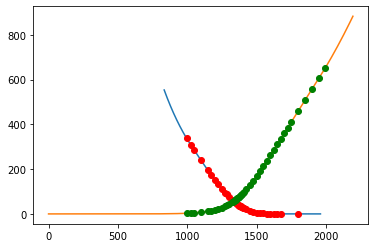

In [17]:
import matplotlib.pyplot as plt

px = np.linspace(0, om.put_strikes[-1] + (om.put_strikes[-1] - om.put_strikes[0]) * 0.2, 200)
pp = om.put_func(px)
#plt.plot(px, pp, om.put_strikes, om.put_prices, 'ro')
#plt.show()

cx = np.linspace(np.maximum(om.call_strikes[0] - 0.2 * (om.call_strikes[-1] - om.call_strikes[0]), 0), 
                om.call_strikes[-1] + 0.2 * (om.call_strikes[-1] - om.call_strikes[0]), 200)
cp = om.call_func(cx)

### plot put and call curves
plt.plot(cx, cp, om.call_strikes, om.call_prices, 'ro',
         px, pp, om.put_strikes, om.put_prices, 'go')
plt.show()

In [230]:
opt_data.head()

,trf_svix2,forward,ttm,date,exdate,impl_vol,bid_ask,strike
0,0.001834,1204.843736,19.0,20050103,2005-01-22,2.029598,0.002838,500.0
1,0.016133,1214.005675,257.0,20050103,2005-09-17,NaN,0.003322,600.0
2,0.022515,1218.993252,348.0,20050103,2005-12-17,NaN,0.002862,500.0
3,0.002360,1205.467483,47.0,20050103,2005-02-19,0.763702,0.003966,700.0
4,0.035437,1229.828712,530.0,20050103,2006-06-17,NaN,0.005741,500.0


In [194]:
opt_data.date.value_counts()

20051108    10
20051110    10
20051121    10
20051031    10
20051202    10
            ..
20050617     7
20050415     7
20050121     7
20050916     7
20050103     7
Name: date, Length: 252, dtype: int64

In [188]:
opt_data.columns

Index(['trf_svix2', 'forward', 'ttm', 'date', 'exdate', 'impl_vol', 'bid_ask',
       'strike'],
      dtype='object')

In [223]:
t=opt_data[opt_data['date']=='20050415']

In [200]:
t

,trf_svix2,forward,ttm,date,exdate,impl_vol,bid_ask,strike
1412,0.009544,1249.076385,183.0,20050916,2006-03-18,NaN,0.003716,700.0
1413,0.015388,1256.297355,274.0,20050916,2006-06-17,NaN,0.002727,500.0
1414,0.001216,1238.990082,36.0,20050916,2005-10-22,NaN,0.004571,800.0
1415,0.027155,1270.990905,456.0,20050916,2006-12-16,NaN,0.004709,600.0
1416,0.039447,1286.533012,638.0,20050916,2007-06-16,NaN,0.005471,700.0
1417,0.002666,1240.522334,64.0,20050916,2005-11-19,NaN,0.004571,800.0
1418,0.004272,1242.391075,92.0,20050916,2005-12-17,NaN,0.002720,500.0


In [201]:
import seaborn as sns

<AxesSubplot:xlabel='strike', ylabel='bid_ask'>

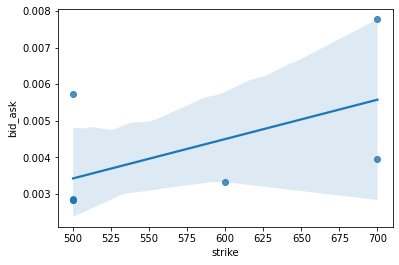

In [218]:
sns.regplot(x='strike',y='bid_ask',data=t)

<AxesSubplot:xlabel='strike', ylabel='bid_ask'>

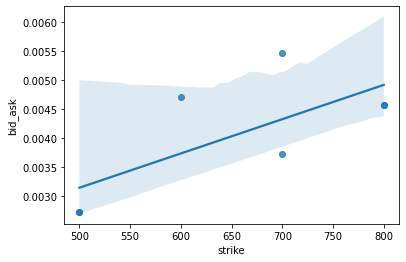

In [220]:
sns.regplot(x='strike',y='bid_ask',data=t)

<AxesSubplot:xlabel='strike', ylabel='bid_ask'>

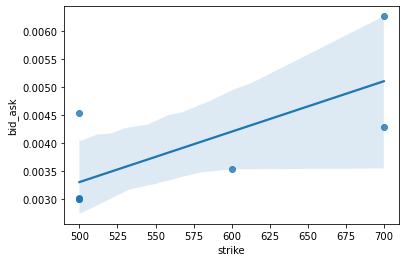

In [222]:
sns.regplot(x='strike',y='bid_ask',data=t)

<AxesSubplot:xlabel='strike', ylabel='bid_ask'>

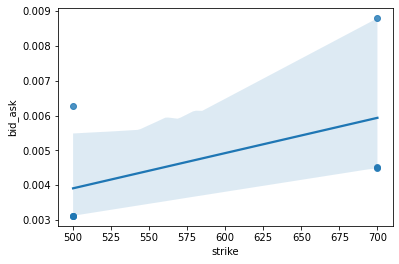

In [224]:
sns.regplot(x='strike',y='bid_ask',data=t)

<AxesSubplot:xlabel='bid_ask', ylabel='ttm'>

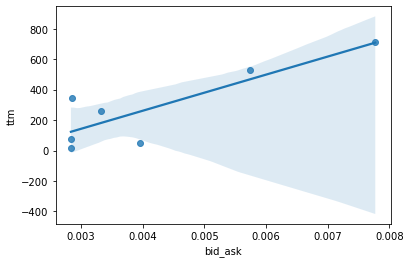

In [217]:
sns.regplot(x='strike',y='bid_ask',data=t)

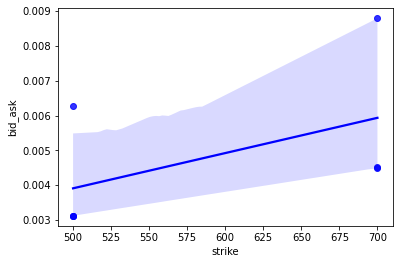

In [226]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(t['strike'],t['bid_ask'])
ax = sns.regplot(x="strike", y="bid_ask", data=t, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})


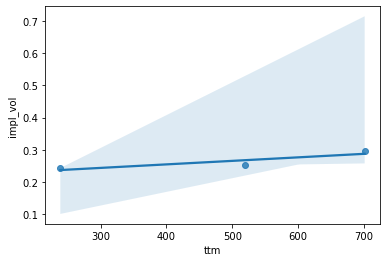

In [105]:
#p=sns.regplot(x="ttm", y="impl_vol", data=t)

In [45]:
p.get_lines()[0].get_xdata()
p.get_lines()[0].get_ydata()

array([-0.00196755, -0.00116716, -0.00036677,  0.00043362,  0.00123401,
        0.00203439,  0.00283478,  0.00363517,  0.00443556,  0.00523595,
        0.00603634,  0.00683673,  0.00763712,  0.0084375 ,  0.00923789,
        0.01003828,  0.01083867,  0.01163906,  0.01243945,  0.01323984,
        0.01404022,  0.01484061,  0.015641  ,  0.01644139,  0.01724178,
        0.01804217,  0.01884256,  0.01964294,  0.02044333,  0.02124372,
        0.02204411,  0.0228445 ,  0.02364489,  0.02444528,  0.02524566,
        0.02604605,  0.02684644,  0.02764683,  0.02844722,  0.02924761,
        0.030048  ,  0.03084839,  0.03164877,  0.03244916,  0.03324955,
        0.03404994,  0.03485033,  0.03565072,  0.03645111,  0.03725149,
        0.03805188,  0.03885227,  0.03965266,  0.04045305,  0.04125344,
        0.04205383,  0.04285421,  0.0436546 ,  0.04445499,  0.04525538,
        0.04605577,  0.04685616,  0.04765655,  0.04845693,  0.04925732,
        0.05005771,  0.0508581 ,  0.05165849,  0.05245888,  0.05

In [242]:
import matplotlib.pyplot as plt

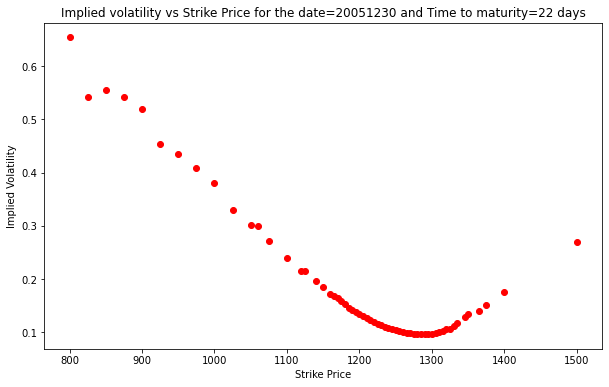

In [261]:
dataframe_19960304=data[data['date']=='20051230']
dataframe_19960304_ttm_12=dataframe_19960304[(dataframe_19960304['ttm']==22) & (dataframe_19960304['cp_flag']=='C')]
plt.figure(figsize=(10, 6))
#sns.regplot(x=dataframe_19960304_ttm_12['strike_price'],y=dataframe_19960304_ttm_12['impl_volatility'],data=dataframe_19960304_ttm_12)
plt.plot(dataframe_19960304_ttm_12['strike_price'],dataframe_19960304_ttm_12['impl_volatility'],'ro')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied volatility vs Strike Price for the date=20051230 and Time to maturity=22 days')
plt.show()

In [245]:
data.date

438       20050103
453       20050103
452       20050103
231       20050103
230       20050103
            ...   
148505    20051230
148509    20051230
148504    20051230
148641    20051230
148640    20051230
Name: date, Length: 149514, dtype: object

In [256]:
dataframe_19960304.ttm.value_counts()

22      120
50      104
78       86
351      80
169      66
722      55
533      46
260      44
1086     24
7        10
Name: ttm, dtype: int64

In [267]:
import py_vollib.black_scholes.implied_volatility


In [275]:
flag = 'c'  # 'c' for call, 'p' for put
S = 100  # Underlying asset price
K = 90  # Strike
t = 0.5  # (Annualized) time-to-expiration
r = 0.01  # Interest free rate
iv = 0.2  # Implied Volatility
price=95

In [276]:
py_vollib.black_scholes.implied_volatility.implied_volatility(price, S, K, t, r, flag)

5.476188990741004

In [277]:
new_df=pd.read_csv('')

15503

In [282]:
data.columns

Index(['secid_x', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag',
       'expiry_indicator', 'root', 'suffix', 'cusip', 'spot', 'secid_y',
       'forwardprice', 'run', 'mid_price', 'ttm', 'bid_ask'],
      dtype='object')

In [286]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException

In [284]:
len(data)

149514

In [285]:
data.impl_volatility.isna().sum()

15503

In [288]:
data.columns

Index(['secid_x', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag',
       'expiry_indicator', 'root', 'suffix', 'cusip', 'spot', 'secid_y',
       'forwardprice', 'run', 'mid_price', 'ttm', 'bid_ask'],
      dtype='object')

In [323]:
a=[]
for i in range(len(data)):
    a.append(data.iloc[i,1][4:6])

In [330]:
np.unique(a)

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype='<U2')

In [ ]:
for i in range(len(data)):
    if pd.isna(data.iloc[i,12]):
        price=data.iloc[i,30]
        spot=data.iloc[i,26]
        strike=data.iloc[i,7]
        ttm=data.iloc[i,31]
        mnth=data.iloc[i,1][4:6]
        
        if mnth=='01':
            rf=(0.43/100)*12
        elif mnth=='02':
            rf=(0.39/100)*12
        elif mnth=='03':
            rf=(0.39/100)*12
        elif mnth=='04':
            rf=(0.46/100)*12
        elif mnth=='05':
            rf=(0.42/100)*12
        elif mnth=='06':
            rf=(0.4/100)*12
        elif mnth=='07':
            rf=(0.45/100)*12
        elif mnth=='08':
            rf=(0.41/100)*12
        elif mnth=='09':
            rf=(0.44/100)*12
        elif mnth=='10':
            rf=(0.42/100)*12
        elif mnth=='11':
            rf=(0.41/100)*12
        elif mnth=='12':
            rf=(0.46/100)*12
    flag=data.iloc[i,6].lower()
    iv=implied_volatility(price,spot,strike,ttm,rf,flag)
    data.at[i,'impl_volatility'] = iv

In [319]:
data.date.value_counts()

20051215    685
20051213    679
20051214    679
20051212    675
20051020    673
           ... 
20050617    496
20050415    494
20050121    492
20050318    478
20050218    472
Name: date, Length: 252, dtype: int64

In [337]:
opt_data.head()

,trf_svix2,forward,ttm,date,exdate,impl_vol,bid_ask,strike
0,0.045613,1109.690557,166.0,20050103,2005-06-18,0.466747,0.002851,500.0
1,0.056853,1109.271378,257.0,20050103,2005-09-17,NaN,0.003322,600.0
2,0.061860,1126.652193,348.0,20050103,2005-12-17,NaN,0.002862,500.0
3,0.051713,1124.951662,75.0,20050103,2005-03-19,0.879292,0.002845,500.0
4,0.035850,1110.543845,165.0,20050104,2005-06-18,NaN,0.002915,500.0


In [343]:
len(data)

149514

In [347]:
os.chdir('/Users/nikunjbhatia/Desktop/Conditional Betas/')

In [371]:
df_rf=pd.read_csv('RF.csv')

In [372]:
df_rf.drop(['Unnamed: 0','MktRF','smb','hml'],axis=1,inplace=True)

In [373]:
df_rf=df_rf[0:1145]

In [374]:
df_rf['rf']=(df_rf['rf']*12)/100
df_rf['yandm'] = pd.to_datetime(df_rf['yandm'], format='%Y%m')
df_rf['yandm'] = df_rf['yandm'].dt.strftime("%Y%m")

In [382]:
import statistics
import math

In [384]:
dataframe_new=pd.DataFrame(columns = ['date','ttm(in yrs)','P/S'])

In [385]:
for i in range(len(data['date'].unique())):
    dated=data['date'].unique()[i]
    risk_free_rate=df_rf[df_rf['yandm']==data['date'].unique()[i][:-2]].iloc[0,1]
    df1=data[data['date']==dated]
    for j in range(len(df['ttm'].unique())):
        time_to_maturity=df1['ttm'].unique()[j]
        time_to_maturity_yrs=(time_to_maturity/365.0)  #Converting ttm to years from months
        df_new=data[(data['date']==dated) & (data['ttm']==time_to_maturity)]
    values=[]
    for k in range(len(df_new[df_new.duplicated(subset=['strike_price'],keep=False)]['strike_price'].unique())):
        sp=df_new[df_new.duplicated(subset=['strike_price'],keep=False)]['strike_price'].unique()[k]
        df_final_C=data[(data['date']==dated) & (data['ttm']==time_to_maturity) & (data['strike_price']==sp) & (data['cp_flag']=='C')]   #Call option
        df_final_P=data[(data['date']==dated) & (data['ttm']==time_to_maturity) & (data['strike_price']==sp) & (data['cp_flag']=='P')]   #Put Option
        exp=((df_final_P.iloc[0,30]-df_final_C.iloc[0,30]+df_final_P.iloc[0,26]-sp*math.exp(risk_free_rate*time_to_maturity_yrs))/df_final_P.iloc[0,26])
        values.append(exp)
    #finding median across strike prices
    if len(values)!=0:
        med_value=statistics.median(map(float,values))
        dataframe_new.loc[len(dataframe_new.index)]=[dated,time_to_maturity_yrs,med_value]  #adding the record to our new dataframe


In [386]:
dataframe_new

,date,ttm(in yrs),P/S
0,20050103,0.052055,-0.003554
1,20050104,0.049315,-0.002381
2,20050105,0.046575,0.000577
3,20050106,0.043836,-0.000324
4,20050107,0.041096,0.000371
...,...,...,...
246,20051223,0.019178,-0.002064
247,20051227,0.008219,-0.001253
248,20051228,0.005479,-0.000777
249,20051229,0.002740,0.000366


In [100]:
# import math
# import statistics
# dataframe_new=pd.DataFrame(columns = ['date','ttm(in yrs)','P/S'])
# for i in range(len(optionsdata_1996['date'].unique())):
#     dated=optionsdata_1996['date'].unique()[i]
#     risk_free_rate=df_rf[df_rf['yandm']==optionsdata_1996['date'].unique()[i][:-2]].iloc[0,1]
#     df=optionsdata_1996[optionsdata_1996['date']==dated]
#     for j in range(len(df['ttm'].unique())):
#         time_to_maturity=df['ttm'].unique()[j]
#         time_to_maturity_yrs=(time_to_maturity/365.0)  #Converting ttm to years from months
#         df_new=optionsdata_1996[(optionsdata_1996['date']==dated) & (optionsdata_1996['ttm']==time_to_maturity)]
#         values=[]
#         for k in range(len(df_new[df_new.duplicated(subset=['strike_price'],keep=False)]['strike_price'].unique())):
#             sp=df_new[df_new.duplicated(subset=['strike_price'],keep=False)]['strike_price'].unique()[k]
#             df_final_C=optionsdata_1996[(optionsdata_1996['date']==dated) & (optionsdata_1996['ttm']==time_to_maturity) & (optionsdata_1996['strike_price']==sp) & (optionsdata_1996['cp_flag']=='C')]   #Call option
#             df_final_P=optionsdata_1996[(optionsdata_1996['date']==dated) & (optionsdata_1996['ttm']==time_to_maturity) & (optionsdata_1996['strike_price']==sp) & (optionsdata_1996['cp_flag']=='P')]   #Put Option
#             exp=((df_final_P.iloc[0,30]-df_final_C.iloc[0,30]+df_final_P.iloc[0,26]-sp*math.exp(risk_free_rate*time_to_maturity_yrs))/df_final_P.iloc[0,26])
#             values.append(exp)
#     #finding median across strike prices
#             if len(values)!=0:
#                 med_value=statistics.median(map(float,values))
#                 dataframe_new.loc[len(dataframe_new.index)]=[dated,time_to_maturity_yrs,med_value]  #adding the record to our new dataframe



In [101]:
# data.columns

In [2]:
import pandas as pd
nn=pd.read_csv('neuralnetworkdata_1996.csv')

In [3]:
nn.head()

,Unnamed: 0,date,Coefficient_1_Put,Coefficient_2_Put,Coefficient_3_Put,Coefficient_4_Put,Coefficient_5_Put,Coefficient_6_Put,Coefficient_7_Put,Intercept_Put,...,Coefficient_5_Call,Coefficient_6_Call,Coefficient_7_Call,Intercept_Call,div_comp1_slope,div_comp1_intercept,svix_slope,svix_intercept,bid_ask_slope,bid_ask_intercept
0,0,19960104,-8.176233,6.799298,-1.940011,0.042591,-0.041019,0.013269,-0.014864,3.462025,...,-0.024785,0.008044,-0.008457,0.795179,0.077681,-0.002056,0.000054,-0.000710,0.000205,-0.092092
1,1,19960105,-7.682273,6.198210,-1.729005,0.042418,-0.040438,0.012976,-0.014970,3.353959,...,-0.028145,0.008917,-0.010105,2.669410,0.077747,-0.001917,0.000054,-0.000792,0.000241,-0.108937
2,2,19960108,-16.625530,16.692888,-5.840889,0.062579,-0.063105,0.021528,-0.020992,5.898654,...,0.034177,-0.013652,0.005816,-4.720284,0.077479,-0.000253,0.000055,-0.001082,0.000055,-0.017561
3,3,19960109,-19.789010,19.135786,-6.197430,0.082023,-0.082932,0.027860,-0.027094,7.051304,...,-0.075880,0.025491,-0.024098,9.472045,0.079880,-0.004829,0.000059,-0.001314,0.000329,-0.157828
4,4,19960110,-19.215024,18.001749,-5.665562,0.080729,-0.079160,0.025811,-0.027484,7.063874,...,-0.019601,0.006861,-0.005690,2.047950,0.081300,-0.002265,0.000058,-0.000633,0.000157,-0.063926


In [4]:
nn.shape

(252, 24)

In [5]:
nn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           252 non-null    int64  
 1   date                 252 non-null    int64  
 2   Coefficient_1_Put    252 non-null    float64
 3   Coefficient_2_Put    252 non-null    float64
 4   Coefficient_3_Put    252 non-null    float64
 5   Coefficient_4_Put    252 non-null    float64
 6   Coefficient_5_Put    252 non-null    float64
 7   Coefficient_6_Put    252 non-null    float64
 8   Coefficient_7_Put    252 non-null    float64
 9   Intercept_Put        252 non-null    float64
 10  Coefficient_1_Call   252 non-null    float64
 11  Coefficient_2_Call   252 non-null    float64
 12  Coefficient_3_Call   252 non-null    float64
 13  Coefficient_4_Call   252 non-null    float64
 14  Coefficient_5_Call   252 non-null    float64
 15  Coefficient_6_Call   252 non-null    flo

In [131]:
user = 'cdavis40'
password = 'TH!7rRS8BNf9z@P'

conn = wrds.Connection(wrds_username = user)

### get all optionm (option metrics) tables
tables = conn.list_tables(library = 'optionm')
tables = sorted(tables)

### read in security info
secinfo = conn.get_table(library = 'optionm', table = 'securd')
secinfo = secinfo.loc[secinfo.ticker == 'AAPL', :]
secid = int(secinfo.secid.values[0])

### read in SPDR data
data = conn.raw_sql("""select * 
                    from optionm.vsurfd2014 
                    where secid = """ + str(secid))

### merge to security info
data = data.merge(secinfo, on = 'secid')

### get prices
#secprc = conn.get_table(library = 'optionm', table = 'secprd2014')
secprc = conn.raw_sql("""select secid, date, close
                      from optionm.secprd2014
                      where secid = """ + str(secid))
secprc.rename(columns = {'close': 'spot'}, inplace = True)
data = data.merge(secprc, on = ['secid', 'date'])

### save data
#data.to_pickle(datadir + 'aapl_surface_2014.pkl')

Loading library list...
Done


In [132]:
import wrds

In [133]:
data

,secid,date,days,delta,impl_volatility,impl_strike,impl_premium,dispersion,cp_flag,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,spot
0,101594.0,2014-01-02,10.0,-90.0,0.417765,605.83400,54.44569,0.250339,P,03783310,AAPL,3571,0,4.0,None,0,NaN,553.13
1,101594.0,2014-01-02,10.0,-85.0,0.323689,585.56800,34.66708,0.177091,P,03783310,AAPL,3571,0,4.0,None,0,NaN,553.13
2,101594.0,2014-01-02,10.0,-80.0,0.270774,574.98940,24.54939,0.089859,P,03783310,AAPL,3571,0,4.0,None,0,NaN,553.13
3,101594.0,2014-01-02,10.0,-75.0,0.254987,569.63040,19.88959,0.035612,P,03783310,AAPL,3571,0,4.0,None,0,NaN,553.13
4,101594.0,2014-01-02,10.0,-70.0,0.251360,565.84190,16.97809,0.017746,P,03783310,AAPL,3571,0,4.0,None,0,NaN,553.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94243,101594.0,2014-12-31,730.0,70.0,0.325776,94.01725,26.60748,0.004047,C,03783310,AAPL,3571,0,4.0,None,0,NaN,110.38
94244,101594.0,2014-12-31,730.0,75.0,0.327627,87.78060,30.23659,0.004898,C,03783310,AAPL,3571,0,4.0,None,0,NaN,110.38
94245,101594.0,2014-12-31,730.0,80.0,0.330187,81.32716,34.42193,0.008478,C,03783310,AAPL,3571,0,4.0,None,0,NaN,110.38
94246,101594.0,2014-12-31,730.0,85.0,0.334843,74.39018,39.42108,0.015216,C,03783310,AAPL,3571,0,4.0,None,0,NaN,110.38


In [134]:
data['date']=pd.to_datetime(data['date'])
data['date'] = data['date'].dt.strftime("%Y%m%d")

In [135]:
data = data.dropna(axis=0, subset=['impl_volatility']) #deleting rows where implied volatility is null

In [84]:
data.iloc[0,17] #finding spot price

553.13

In [85]:
data.iloc[0,5]  #finding implied strike

605.834

In [86]:
df_rf=pd.read_csv('RF.csv',index_col=[0])
df_rf=df_rf[0:1145]
df_rf.drop(labels=['MktRF', 'smb','hml'], axis=1,inplace = True)
df_rf['rf']=(df_rf['rf']*12)/100
df_rf['yandm'] = pd.to_datetime(df_rf['yandm'], format='%Y%m')
df_rf['yandm'] = df_rf['yandm'].dt.strftime("%Y%m")
df_rf[df_rf['yandm']==data['date'].unique()[0][:-2]].iloc[0,1]

0.0

In [87]:
df_rf

,yandm,rf
0,192607,0.0264
1,192608,0.0300
2,192609,0.0276
3,192610,0.0384
4,192611,0.0372
...,...,...
1140,202107,0.0000
1141,202108,0.0000
1142,202109,0.0000
1143,202110,0.0000


In [88]:
import math
import statistics
import option_util as util
dataframe_new=pd.DataFrame(columns = ['date','ttm(in yrs)','P/S'])
for i in range(len(data['date'].unique())):
    
    dated=data['date'].unique()[i]
    risk_free_rate=df_rf[df_rf['yandm']==data['date'].unique()[i][:-2]].iloc[0,1]
    df=data[data['date']==dated]
    for j in range(len(df['days'].unique())):
        
        time_to_maturity=df['days'].unique()[j]
        time_to_maturity_yrs=(time_to_maturity/365.0)  #Converting ttm to years from months
        df_new=data[(data['date']==dated) & (data['days']==time_to_maturity)]
    values=[]
    df_final_C=data[(data['date']==dated) & (data['days']==time_to_maturity) & (data['cp_flag']=='C')]   #Call option
    df_final_P=data[(data['date']==dated) & (data['days']==time_to_maturity) & (data['cp_flag']=='P')]   #Put Option
    length=len(df_final_C)
    my_svix2 = util.svix2(np.flip(df_final_P.impl_strike.values), np.flip(df_final_P.impl_premium.values), np.flip(df_final_C.impl_strike.values), np.flip(df_final_C.impl_premium.values), np.mean(df_new.spot))
    my_svix2.clean()
    my_svix2.fit()
    for k in range(length):
        strikeprice_call=df_final_C.iloc[k,5]  
        spot_price=df_final_C.iloc[k,17]
        call_option_price=df_final_C.iloc[k,6]  #call_option_premium
        put_option_price = my_svix2.put_func(strikeprice_call)
        exp=((put_option_price-call_option_price+spot_price-strikeprice_call*math.exp(risk_free_rate*time_to_maturity_yrs))/spot_price)
        values.append(exp)
    for l in range(length):
        strikeprice_put=df_final_P.iloc[k,5]  
        spot_price=df_final_P.iloc[k,17]
        put_option_price=df_final_P.iloc[k,6]  #put_option_premium
        call_option_price = my_svix2.call_func(strikeprice_put)
        exp=((put_option_price-call_option_price+spot_price-strikeprice_put*math.exp(risk_free_rate*time_to_maturity_yrs))/spot_price)
        values.append(exp)
      #finding median across strike prices
    if len(values)!=0:
        med_value=statistics.median(map(float,values))
        dataframe_new.loc[len(dataframe_new.index)]=[dated,time_to_maturity_yrs,med_value]  #adding the record to our new dataframe




In [91]:
dataframe_new['P/S']=dataframe_new['P/S']*(-1)
dataframe_new['date']=pd.to_datetime(dataframe_new['date'],format="%Y%m%d")
dataframe_new['date'] = dataframe_new['date'].dt.strftime("%Y%m%d")

In [97]:
import matplotlib.pyplot as plt
dataframe_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         252 non-null    object 
 1   ttm(in yrs)  252 non-null    float64
 2   P/S          252 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.9+ KB


In [96]:
dataframe_new

,date,ttm(in yrs),P/S
0,20140102,2.0,-0.019528
1,20140103,2.0,-0.019492
2,20140106,2.0,-0.019264
3,20140107,2.0,-0.019286
4,20140108,2.0,-0.022397
...,...,...,...
247,20141224,2.0,-0.005180
248,20141226,2.0,-0.007591
249,20141229,2.0,-0.008442
250,20141230,2.0,-0.009548


In [98]:
dataframe_nn_2=pd.DataFrame(columns = ['date','div_comp1_slope','div_comp1_intercept'])
for i in range(len(dataframe_new['date'].unique())):
    d=dataframe_new['date'].unique()[i]
    df_calculate_2=dataframe_new[dataframe_new['date']==d]
    m, b = np.polyfit(df_calculate_2['ttm(in yrs)'], df_calculate_2['P/S'], 1)
    dataframe_nn_2.loc[len(dataframe_nn_2)]=[d,m,b]  #adding the record to our new dataframe

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/test_

In [99]:
dataframe_nn_2

,date,div_comp1_slope,div_comp1_intercept
0,20140102,-0.004882,-0.009764
1,20140103,-0.004873,-0.009746
2,20140106,-0.004816,-0.009632
3,20140107,-0.004822,-0.009643
4,20140108,-0.005599,-0.011198
...,...,...,...
247,20141224,-0.001295,-0.002590
248,20141226,-0.001898,-0.003795
249,20141229,-0.002110,-0.004221
250,20141230,-0.002387,-0.004774


In [102]:
import option_util as util
import datetime
# outdir='/content/drive/My Drive/Conditional_Betas/marketoptions1996_AAPL_chunks_2/'
outdir='/Users/nikunjbhatia/Desktop/Conditional Betas/chunks/'
### index by date * ttm 
N = data[['date', 'days']].drop_duplicates().shape[0]
bar = util.bar(N)
kk = 0
data.index = data.date
undates = np.unique(data.date)
for date in undates:
    date_data = data.loc[date, :]
    ttms = np.unique(date_data.days)
    for ttm in ttms:
        sdata = date_data.loc[date_data.days == ttm, :]
        sdata.index = np.arange(sdata.shape[0])
        savefile = outdir + str(date)[:10] + '_' + str(ttm) + '.pkl.bz2'
        sdata.to_pickle(savefile)
        kk += 1
        bar.update(kk)

### finish
bar.finish()

[=====================================================] 2772 100% Time: 0:00:04


In [104]:
import numpy as np
import pandas as pd
import option_util as util
import os


chunkdir='/Users/nikunjbhatia/Desktop/Conditional Betas/chunks/'

### read in chunks 
files = sorted(os.listdir(chunkdir))
N = len(files)
bar = util.bar(N)
opt_data = []
for ii, file in enumerate(files):
    bar.update(ii)
    
    data = pd.read_pickle(chunkdir + file)
    puts = data.loc[data.cp_flag == 'P', :]
    calls = data.loc[data.cp_flag == 'C', :]
    
    om = util.svix2(np.flip(puts.impl_strike.values), 
                    np.flip(puts.impl_premium.values), 
                    np.flip(calls.impl_strike.values), 
                    np.flip(calls.impl_premium.values),
                    np.mean(data.spot))
    

    success = om.calc_svix2()
    if success == False:
        continue
    trf_svix2 = om.trf_svix2
    forward = om.forward
    ttm = np.mean(data.days)
    date = data.date[0]
    #exdate = data.exdate[0]
    impl_vol=data.impl_volatility[0]
    #bid_ask=data.bid_ask[0]
    strike=data.impl_strike[0]
    
    ### compile data
    opt_data.append({'trf_svix2': trf_svix2, 'forward': forward,
                     'ttm': ttm, 'date': date,  'impl_vol':impl_vol,'strike':strike})

### finish and save
bar.finish()
opt_data = pd.DataFrame(opt_data)

print('finished')


finished


In [105]:
opt_data

,trf_svix2,forward,ttm,date,impl_vol,strike
0,0.001918,553.261618,10.0,20140102,0.417765,605.8340
1,0.027956,551.446020,122.0,20140102,0.286337,692.2083
2,0.034016,549.428363,152.0,20140102,0.277221,707.0041
3,0.040451,549.265206,182.0,20140102,0.274185,722.6995
4,0.061775,547.210551,273.0,20140102,0.272954,774.2372
...,...,...,...,...,...,...
2767,0.089596,109.691881,365.0,20141231,0.267326,162.8801
2768,0.140143,109.628249,547.0,20141231,0.272753,184.5794
2769,0.015142,110.283911,60.0,20141231,0.274060,127.8300
2770,0.196129,109.912569,730.0,20141231,0.280164,205.9920


In [114]:
dataframe_nn_3=pd.DataFrame(columns = ['date','svix_slope','svix_intercept'])
for i in range(len(opt_data['date'].unique())):
    d=opt_data['date'].unique()[i]
    df_calculate_3=opt_data[opt_data['date']==d]
    m, b = np.polyfit(df_calculate_3['ttm'], df_calculate_3['trf_svix2'], 1)
    dataframe_nn_3.loc[len(dataframe_nn_3)]=[d,m,b]  #adding the record to our new dataframe

In [115]:
dataframe_nn_3

,date,svix_slope,svix_intercept
0,20140102,0.000238,-0.000992
1,20140103,0.000241,-0.000056
2,20140106,0.000240,-0.000671
3,20140107,0.000234,-0.001140
4,20140108,0.000226,-0.001579
...,...,...,...
247,20141224,0.000268,-0.004521
248,20141226,0.000264,-0.004751
249,20141229,0.000262,-0.004613
250,20141230,0.000259,-0.003889


<AxesSubplot:xlabel='trf_svix2', ylabel='ttm'>

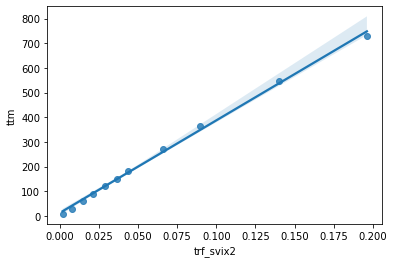

In [117]:
import seaborn as sns
t=opt_data[opt_data['date']=='20141231']
sns.regplot(x='trf_svix2',y='ttm',data=t)

In [120]:
# import pickle
# tickers= pickle.load('date_cusip_pairs.pkl')

In [136]:
stocksdata=data

In [137]:
stocksdata['date']=pd.to_datetime(stocksdata['date'])

In [138]:
stocksdata['ss1']=stocksdata['impl_strike']/stocksdata['spot']
stocksdata['ss2']=stocksdata['ss1']**2
stocksdata['ss3']=stocksdata['ss1']**3
stocksdata['ss1t']=stocksdata['ss1']*stocksdata['days']
stocksdata['ss2t']=stocksdata['ss2']*stocksdata['days']
stocksdata['ss3t']=stocksdata['ss3']*stocksdata['days']

In [139]:
from sklearn.linear_model import LinearRegression
dataframe_nn_1_initial=pd.DataFrame(columns = ['date','cp_flag','Coefficient_1','Coefficient_2','Coefficient_3','Coefficient_4','Coefficient_5','Coefficient_6','Coefficient_7','Intercept'])
for i in range(len(stocksdata['date'].unique())):
    d=stocksdata['date'].unique()[i]
    for j in range(len(stocksdata['cp_flag'].unique())):
        option_type=stocksdata['cp_flag'].unique()[j]
        dataframe_req=stocksdata[(stocksdata['date']==d) & (stocksdata['cp_flag']==option_type)]
        model = LinearRegression()
        y=dataframe_req['impl_volatility']
        x=dataframe_req[['date','cp_flag','impl_strike','ss1','ss2','ss3','ss1t','ss2t','ss3t','days','impl_volatility']]
        model.fit(x[x.columns[3:-1]], y)
        y_pred = model.predict(x[x.columns[3:-1]])
        x['pred_volatility']=y_pred.tolist()
        dataframe_nn_1_initial.loc[len(dataframe_nn_1_initial.index)]=[d,option_type,model.coef_[0],model.coef_[1],model.coef_[2],model.coef_[3],model.coef_[4],model.coef_[5],model.coef_[6],model.intercept_]  #adding the record to our new dataframe

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [164]:

dataframe_nn_1_initial['date']=pd.to_datetime(dataframe_nn_1_initial['date'])
dataframe_nn_1_initial['date'] = dataframe_nn_1_initial['date'].dt.strftime("%Y%m%d")
dataframe_nn_1_initial

,date,cp_flag,Coefficient_1,Coefficient_2,Coefficient_3,Coefficient_4,Coefficient_5,Coefficient_6,Coefficient_7,Intercept
0,20140102,P,-1.193323,1.098317,-0.340628,0.001290,-0.001266,0.000414,-0.000448,0.725880
1,20140102,C,-2.138157,1.795706,-0.495451,0.003017,-0.002530,0.000699,-0.001187,1.130998
2,20140103,P,-0.587949,0.615453,-0.218073,0.000190,-0.000389,0.000194,-0.000032,0.496633
3,20140103,C,-1.824188,1.536339,-0.428742,0.002170,-0.001829,0.000519,-0.000885,1.024493
4,20140106,P,-0.824354,0.695961,-0.208223,0.000908,-0.000796,0.000249,-0.000365,0.625392
...,...,...,...,...,...,...,...,...,...,...
499,20141229,C,-4.420944,3.374040,-0.837823,0.006245,-0.004786,0.001189,-0.002600,2.163216
500,20141230,P,-2.101653,1.490787,-0.339165,0.003191,-0.002347,0.000547,-0.001357,1.224028
501,20141230,C,-3.270885,2.483790,-0.613218,0.004503,-0.003443,0.000852,-0.001873,1.681389
502,20141231,P,-0.799879,0.325309,-0.011086,0.001092,-0.000474,0.000023,-0.000618,0.767831


In [165]:
df_P=dataframe_nn_1_initial[dataframe_nn_1_initial['cp_flag']=='P']
df_C=dataframe_nn_1_initial[dataframe_nn_1_initial['cp_flag']=='C']

In [166]:
m1=df_P.merge(df_C, on=["date"])
m2=m1.merge(dataframe_nn_3, on=["date"])
df_final=m2.merge(dataframe_nn_2, on=["date"])

In [167]:
df_final

,date,cp_flag_x,Coefficient_1_x,Coefficient_2_x,Coefficient_3_x,Coefficient_4_x,Coefficient_5_x,Coefficient_6_x,Coefficient_7_x,Intercept_x,...,Coefficient_3_y,Coefficient_4_y,Coefficient_5_y,Coefficient_6_y,Coefficient_7_y,Intercept_y,svix_slope,svix_intercept,div_comp1_slope,div_comp1_intercept
0,20140102,P,-1.193323,1.098317,-0.340628,0.001290,-0.001266,0.000414,-0.000448,0.725880,...,-0.495451,0.003017,-0.002530,0.000699,-0.001187,1.130998,0.000238,-0.000992,-0.004882,-0.009764
1,20140103,P,-0.587949,0.615453,-0.218073,0.000190,-0.000389,0.000194,-0.000032,0.496633,...,-0.428742,0.002170,-0.001829,0.000519,-0.000885,1.024493,0.000241,-0.000056,-0.004873,-0.009746
2,20140106,P,-0.824354,0.695961,-0.208223,0.000908,-0.000796,0.000249,-0.000365,0.625392,...,-0.484090,0.002930,-0.002231,0.000569,-0.001293,1.313752,0.000240,-0.000671,-0.004816,-0.009632
3,20140107,P,-1.103821,0.920967,-0.264984,0.001369,-0.001165,0.000342,-0.000543,0.729026,...,-0.777751,0.004753,-0.003912,0.001061,-0.001903,1.664749,0.000234,-0.001140,-0.004822,-0.009643
4,20140108,P,-2.527729,2.343720,-0.709315,0.003063,-0.002943,0.000917,-0.001051,1.178661,...,-0.480157,0.003089,-0.002749,0.000792,-0.001111,0.935294,0.000226,-0.001579,-0.005599,-0.011198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,20141224,P,-3.364973,2.481219,-0.587991,0.005645,-0.004275,0.001029,-0.002313,1.724102,...,-0.725277,0.005863,-0.004356,0.001033,-0.002484,2.082587,0.000268,-0.004521,-0.001295,-0.002590
248,20141226,P,-2.753265,2.076774,-0.518017,0.004034,-0.003086,0.000772,-0.001660,1.456989,...,-0.924886,0.006832,-0.005229,0.001296,-0.002849,2.355045,0.000264,-0.004751,-0.001898,-0.003795
249,20141229,P,-2.225351,1.570848,-0.359347,0.003325,-0.002391,0.000548,-0.001430,1.279813,...,-0.837823,0.006245,-0.004786,0.001189,-0.002600,2.163216,0.000262,-0.004613,-0.002110,-0.004221
250,20141230,P,-2.101653,1.490787,-0.339165,0.003191,-0.002347,0.000547,-0.001357,1.224028,...,-0.613218,0.004503,-0.003443,0.000852,-0.001873,1.681389,0.000259,-0.003889,-0.002387,-0.004774


In [168]:
df_final.columns

Index(['date', 'cp_flag_x', 'Coefficient_1_x', 'Coefficient_2_x',
       'Coefficient_3_x', 'Coefficient_4_x', 'Coefficient_5_x',
       'Coefficient_6_x', 'Coefficient_7_x', 'Intercept_x', 'cp_flag_y',
       'Coefficient_1_y', 'Coefficient_2_y', 'Coefficient_3_y',
       'Coefficient_4_y', 'Coefficient_5_y', 'Coefficient_6_y',
       'Coefficient_7_y', 'Intercept_y', 'svix_slope', 'svix_intercept',
       'div_comp1_slope', 'div_comp1_intercept'],
      dtype='object')